# Forecasting Ride Demand

### Input (*filenames can be user-specified*)
- `train.csv`: as provided by the challenge
- `test.csv`: exact same format with train data, containing **14 days** of data up to time T
- `zone_labels.csv`: pre-generated and should be found in ./input/ in the repo. If not, it can be generated from this [notebook](explore_function_segmentation.ipynb).

### Output
- `output.csv`: exact same format with train data, containing forecast values from T+1 to T+5 for all TAZs

### Annotation
- TAZ: traffic analysis zone, as per geohash6 in the data
- timestep (T): 15-minute time interval

# 0. Setup

In [1]:
# general import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional import
import geohash
import lightgbm as lgb

# local import
from rdforecast import datasets, models

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. Data Preparation

## 1.1 Configuration
- Specify folder path for input files
- If the repo is cloned/downloaded as a whole, the defaults should do.

In [2]:
# path to train, test, and zone_label data
path = './input/'  # <<< specify input folder

# specify historical demands to generate features
# NOTE: do NOT modify this
history = [1, 2, 5,
           96, 96*7, 96*14,
           96+1, 96*7+1, 96*14+1,
           96+5, 96*7+5, 96*14+5]

## 1.2 Load datasets
- Manually move both the training data and the hold-out testing data into the input folder.
- ([Training Data Source](https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip), or use `datasets.load_training_data` to download from URL)
- Check if `zone_labels.csv` exists
- Specify respective filenames as needed, the remaining codes should work out themselves.

In [3]:
# retrieve data from source url (optional)
# train = datasets.load_training_data(filepath=None)
# train = datasets.check_sanity(train)

# additionally, split into train and test when developing
# when testing with external hold-out test data, this whole file
# should be used solely as train and valid instead
# train, test = datasets.split_train_test(train, n_days=14, path=path)

In [4]:
# NOTE: zone_labels.csv is pre-generated and should be found in ./input/
# If not, it can be generated from explore_function_segmentation.ipynb
zone_labels = pd.read_csv(path+'zone_labels.csv')

In [5]:
# prepare train data
train = pd.read_csv(path+'train.csv')  # <<< specify filename

train = datasets.process_timestamp(train)
train = train.merge(zone_labels, how='left', on='geohash6')
train_full = models.expand_timestep(train, test_data=False)  # test_data=False
train_full = models.generate_features(train_full, history)

Decoding geohash...
Expanding training data and fill NaNs with 0 demands for all timesteps per TAZ...
Might take a moment depending on machines...
Done.
Missing values:
geohash6            0
timestep            0
label_weekly_raw    0
label_weekly        0
label_daily         0
label_quarterly     0
active_rate         0
lon                 0
lat                 0
day                 0
weekly              0
quarter             0
hour                0
dow                 0
demand              0
dtype: int64
Retrieving historical demands...
Generating features...
Done.


In [6]:
# prepare test data
test = pd.read_csv(path+'test.csv')  # <<< specify filename

test = datasets.process_timestamp(test)
test = test.merge(zone_labels, how='left', on='geohash6')
test_full = models.expand_timestep(test, test_data=True)  # test_data=True
test_full = models.generate_features(test_full, history)

Decoding geohash...
Expanding testing data and fill NaNs with 0 demands for all timesteps per TAZ; also generating T+1 to T+5 slots for forecasting...
Might take a moment depending on machines...
Done.
Missing values:
geohash6            0
timestep            0
label_weekly_raw    0
label_weekly        0
label_daily         0
label_quarterly     0
active_rate         0
lon                 0
lat                 0
day                 0
weekly              0
quarter             0
hour                0
dow                 0
demand              0
dtype: int64
Retrieving historical demands...
Generating features...
Done.


## 1.3 Prepare data for model training and forecasting
- You might wish to specify the split day for train and validation in the second cell.
    - For the two months training data downloaded from the URL, **47** is suggested, leaving two weeks of data for validation.
    - For model developing use (which is for the author myself), **40** is used since the final two weeks in the training data are already reserved as test data. Thus, one week data is split for validation.

In [7]:
# NOTE: there is no need to modify this cell to proceed
# specify features to use (do not include 'geohash6' and 'demand')
features = ['timestep', 'label_weekly_raw', 'label_daily',
            'active_rate', 'day', 'weekly', 'quarter',
            'hour', 'dow', 'demand_t-1', 'demand_t-2',
            'demand_t-5', 'demand_t-96', 'demand_t-672',
            'demand_t-1344', 'demand_t-97', 'demand_t-101',
            'weekend', 'st_trend', 'mt_trend', 'mt_trend_1d',
            'mt_trend_1w', 'lt_trend_1d']

# specify which features to be treated as categorical
cate_vars = ['hour', 'dow', 'label_weekly_raw', 'label_daily']

In [8]:
# NOTE: data in train_full whose
#       'day <= split' will be used as train data, and
#       'day >  split' will be used as validation data

# specify on which day to split train and validation
split = 40  # <<< specify split

# generate training set and validation set based on features
X_train, X_val, y_train, y_val = models.get_train_validate(train_full, features, split)
X_train, X_val = models.mitigate_history(X_train, X_val)

[dtypes of features (including demand):]
float64    20
int64       4
dtype: int64

Split train and validation sets on day 40

40 days in train set.
X_train: (5084160, 23)
y_train: (5084160,)

7 days in validation set.
X_val: (889728, 23)
y_val: (889728,)


In [9]:
# NOTE: there is no need to modify or specify a split here,
#       T+1 to T+5 horizons will be automatically
#       generated as X_forecast and y_forecast
# generate testing set and forecasting set based on features
# NOTE: in current version, only X_forecast set will be used later
X_test, X_forecast, y_test, y_forecast = models.get_test_forecast(test_full, features)

[dtypes of features (including demand):]
float64    20
int64       4
dtype: int64

Split test and forecast sets
X_test: (1759296, 23)
y_test: (1759296,)
X_forecast: (7854, 23)
y_forecast: (7854,)


# 2. Modelling

## 2.1 Model training

In [10]:
# NOTE: there is no need to modify this cell to proceed
# configure model params
params = {
    'num_leaves': 2**5,
    'objective': 'regression_l2',
    'max_depth': 10,
    'min_data_in_leaf': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'rmse',
    'num_threads': 8
}

# start training
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cate_vars)
dval = lgb.Dataset(X_val, label=y_val, categorical_feature=cate_vars, reference=dtrain)
bst = lgb.train(params, dtrain, valid_sets=[dtrain, dval],
                num_boost_round=1000,
                early_stopping_rounds=100,
                verbose_eval=50)

# report feature importance
print('\n'.join(('%s: %.2f' % x) for x in sorted(
      zip(X_train.columns, bst.feature_importance('gain')),
      key=lambda x: x[1], reverse=True)))

/home/yuwen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/yuwen/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.0806036	valid_1's rmse: 0.084061
[100]	training's rmse: 0.054795	valid_1's rmse: 0.0569849
[150]	training's rmse: 0.0405776	valid_1's rmse: 0.0423142
[200]	training's rmse: 0.033249	valid_1's rmse: 0.0349678
[250]	training's rmse: 0.0296615	valid_1's rmse: 0.0315411
[300]	training's rmse: 0.0278634	valid_1's rmse: 0.0299627
[350]	training's rmse: 0.0268979	valid_1's rmse: 0.0292509
[400]	training's rmse: 0.0263418	valid_1's rmse: 0.0289082
[450]	training's rmse: 0.025934	valid_1's rmse: 0.0287177
[500]	training's rmse: 0.025642	valid_1's rmse: 0.0286087
[550]	training's rmse: 0.0254241	valid_1's rmse: 0.0285471
[600]	training's rmse: 0.0252645	valid_1's rmse: 0.028516
[650]	training's rmse: 0.025097	valid_1's rmse: 0.0285275
[700]	training's rmse: 0.0249649	valid_1's rmse: 0.0285469
Early stopping, best iteration is:
[627]	training's rmse: 0.0251728	valid_1's rmse: 0.0285042
demand_t-5: 1750734.91
de

## 2.2 Model prediction

### 2.2.1 baselines

In [11]:
# extract some baselines for output comparisons
models.get_baselines(train_full)

[Simple Baselines]
Naive T-1:
0.02580025354015726
Naive T-96 (1 day):
0.052818481811111956
Naive T-672 (1 week):
0.0497953774293416
T-1 + (T-96 - T-97):
0.0347300497319869
T-1 + (T-672 - T-673):
0.03828125904391044
Historical average (by 672 timesteps weekly cycle per TAZ):
0.034347577265756185


### 2.2.2 predict on test data (from T - 14 days up to T)

In [12]:
y_pred = models.cap(bst.predict(X_test))
print('Before mitigation:')
models.eval_RMSE(y_test, y_pred)

# mitigate history information in test set
X_test.loc[X_test.sample(frac=0.4).index, ['demand_t-1', 'st_trend', 'mt_trend']] = -1
X_test.loc[X_test.sample(frac=0.3).index, ['demand_t-2']] = -1

print('After mitigation:')
y_pred = models.cap(bst.predict(X_test))
models.eval_RMSE(y_test, y_pred)

Before mitigation:
0.025283771768641376
After mitigation:
0.028861373440291976


### 2.2.3 perform forecast (from T+1 to T+5)
- You may specify a folder path (e.g., './output/') to export forecast results for further evaluation.
- You may adjust the `shift` argument to generate different outputs:
    - When shift is True, the forecast horizons will be shifted one timestep forward. This trick may yield an overall better performance compared with the original forecast values. In other words, there may be a potential 1-step lag in the forecast model.

In [13]:
output_path = './output/'  # <<< specify folder path
y_forecast = bst.predict(X_forecast)
output = models.get_forecast_output(test_full, y_forecast, shift=False, path=output_path)
output = models.get_forecast_output(test_full, y_forecast, shift=True, path=output_path)
output.head(10)

Saving forecast output to ./output/
Done.

[INFO] Forecast output values shifted (1T).
Saving forecast output to ./output/
Done.


,geohash6,day,timestamp,demand
0,qp02yc,62,0:0,0.031686
1,qp02yc,62,0:15,0.028228
2,qp02yc,62,0:30,0.027217
3,qp02yc,62,0:45,0.034829
4,qp02yc,62,1:0,0.038024
5,qp02yf,62,0:0,0.062656
6,qp02yf,62,0:15,0.055319
7,qp02yf,62,0:30,0.044212
8,qp02yf,62,0:45,0.069213
9,qp02yf,62,1:0,0.065020


### Forecast complete!
> The model ends here, but feel free to carry on some analyses using the codes prepared below.

## 2.3 Model evaluation

### 2.3.1 visualization

In [14]:
# recover test set info
# TODO: set index aforehand to avoid the trouble
split = test_full['timestep'].max() - 6
X_test_ = test_full[test_full['timestep'] <= split]
result = pd.concat([X_test_.reset_index(drop=True), pd.Series(y_test.values), pd.Series(y_pred)], axis=1, ignore_index=True)
result.columns = list(X_test_.columns) + ['y_test', 'y_pred']
result['geohash6'] = [geohash.encode(lat, lon, 6) for lon, lat in zip(result['lon'], result['lat'])]

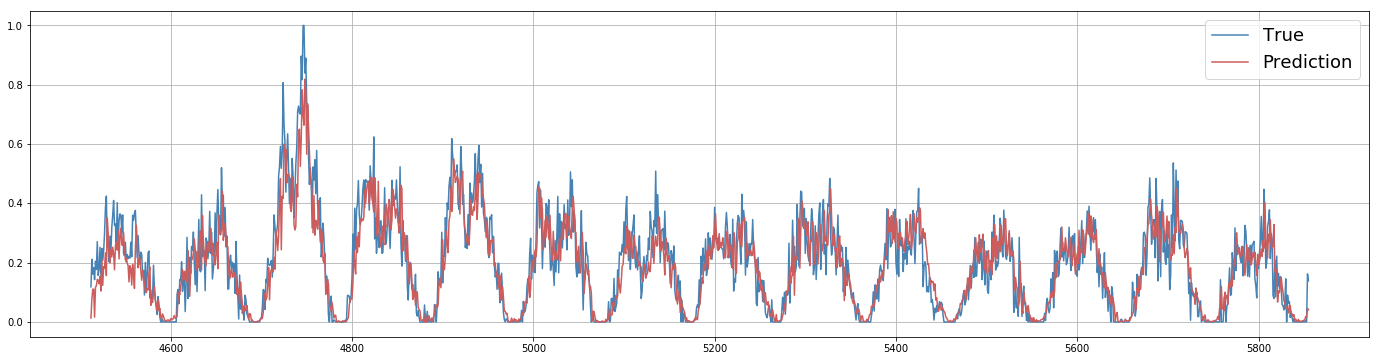

In [15]:
# long-term window
taz = 'qp02zt'
models.plot_forecast(result, taz)

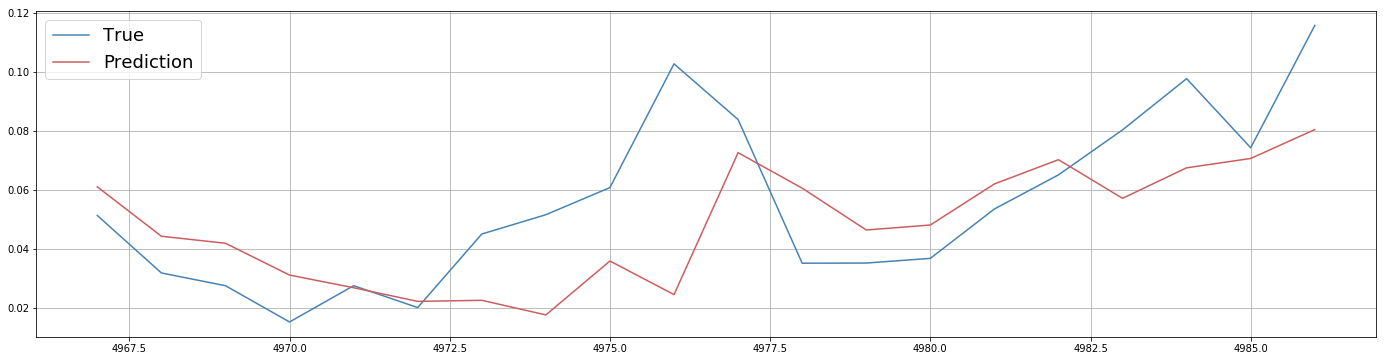

In [16]:
# short-term window
s = 455
e = 475
taz = 'qp03r0'
models.plot_forecast(result, taz, s, e)

### 2.3.1 errors

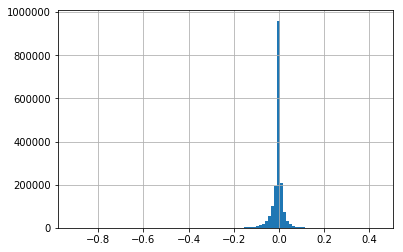

In [17]:
result['diff'] = (y_pred - y_test)
result['diff'].hist(bins=100);

#### analyze by zones that have higher errors

In [18]:
bad = result[np.abs(result['diff']) >= result['diff'].std() * 3]
good = result[np.abs(result['diff']) <= 0.001]

In [19]:
bad['geohash6'].value_counts()[:5]

qp0d1c    337
qp099w    331
qp03xr    331
qp0d17    320
qp03tc    308
Name: geohash6, dtype: int64

In [20]:
good['geohash6'].value_counts()[:5]

qp03yn    1185
qp09md    1182
qp09n1    1180
qp09vb    1179
qp093h    1175
Name: geohash6, dtype: int64

#### analyze by zone functions (temporal pattern clustering labels)

In [21]:
i = 3
result[result['label_weekly_raw'] == i]['geohash6'].unique()[:10]

array(['qp096z', 'qp02zz', 'qp09dc', 'qp096x', 'qp03wf', 'qp02zw',
       'qp096v', 'qp09eq', 'qp096r', 'qp03qg'], dtype=object)